In [9]:
import time
from functools import partial
from IPython.display import display
from itertools import product

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score

from utils import (
    load, 
    select_datetime_columns,
    transform_datetime_features,
    transform_data,
    make_predictions,
    predict,
    root_mean_squared_error,
    pprint
)

In [10]:
task = 1
df_x, target = load(task, 'train')
_, y_test = load(task, 'test-target')
x_test, _ = load(task, 'test')

In [3]:
df_x.shape

(365, 41)

In [4]:
datetime_columns = select_datetime_columns(df_x)
old_features = list(df_x.columns)
df_x = transform_datetime_features(df_x, datetime_columns)
dt_dt_features = [col for col in df_x.columns if col not in old_features]

In [5]:
dt_dt_features, df_x.columns

(['dt_number_weekday_datetime_0',
  'dt_number_month_datetime_0',
  'dt_number_day_datetime_0',
  'dt_number_hour_datetime_0',
  'dt_number_hour_of_week_datetime_0',
  'dt_number_minute_of_day_datetime_0'],
 Index(['datetime_0', 'number_0', 'number_1', 'number_2', 'number_3',
        'number_4', 'number_5', 'number_6', 'number_7', 'number_8', 'number_9',
        'number_10', 'number_11', 'number_12', 'number_13', 'number_14',
        'number_15', 'number_16', 'number_17', 'number_18', 'number_19',
        'number_20', 'number_21', 'number_22', 'number_23', 'number_24',
        'number_25', 'number_26', 'number_27', 'number_28', 'number_29',
        'number_30', 'number_31', 'number_32', 'number_33', 'number_34',
        'number_35', 'number_36', 'number_37', 'number_38', 'line_id',
        'dt_number_weekday_datetime_0', 'dt_number_month_datetime_0',
        'dt_number_day_datetime_0', 'dt_number_hour_datetime_0',
        'dt_number_hour_of_week_datetime_0',
        'dt_number_minute_o

In [6]:
df_x.datetime_0.nunique()

365

In [7]:
df_x.sort_values('datetime_0')[dt_dt_features].head(35)

,dt_number_weekday_datetime_0,dt_number_month_datetime_0,dt_number_day_datetime_0,dt_number_hour_datetime_0,dt_number_hour_of_week_datetime_0,dt_number_minute_of_day_datetime_0
323,0,1,9,0,0,0
1,1,1,10,0,24,0
124,2,1,11,0,48,0
69,3,1,12,0,72,0
202,4,1,13,0,96,0
342,5,1,14,0,120,0
107,6,1,15,0,144,0
109,0,1,16,0,0,0
164,1,1,17,0,24,0
102,2,1,18,0,48,0


- Данные по дням за год
- dt_number_hour_of_week_datetime_0 - количество часов с начала недели. Всего в неделе 168 часов, но тут максимальное значение 144, что соответствует 6 дням. Вероятно один день в неделю записи не появлялись в БД (скорее всего в вс)
- dt_number_minute_of_day_datetime_0 заполнены нулями, поэтому скорее всего это транзакции

In [8]:
df_x[dt_dt_features].describe()

,dt_number_weekday_datetime_0,dt_number_month_datetime_0,dt_number_day_datetime_0,dt_number_hour_datetime_0,dt_number_hour_of_week_datetime_0,dt_number_minute_of_day_datetime_0
count,365.000000,365.000000,365.000000,365.0,365.000000,365.0
mean,2.991781,6.526027,15.720548,0.0,71.802740,0.0
std,2.006155,3.452584,8.808321,0.0,48.147718,0.0
min,0.000000,1.000000,1.000000,0.0,0.000000,0.0
25%,1.000000,4.000000,8.000000,0.0,24.000000,0.0
50%,3.000000,7.000000,16.000000,0.0,72.000000,0.0
75%,5.000000,10.000000,23.000000,0.0,120.000000,0.0
max,6.000000,12.000000,31.000000,0.0,144.000000,0.0


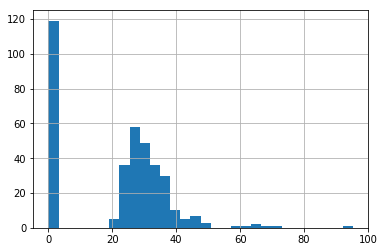

In [9]:
target.hist(bins=30)
plt.show()

In [10]:
target.describe()

count    365.000000
mean      21.605257
std       16.731888
min        0.000000
25%        0.000000
50%       27.186048
75%       32.193718
max       95.249705
Name: target, dtype: float64

Видно, что большая часть нулей по выходным + иногда по (праздникам?)

In [11]:
df = df_x.sort_values('datetime_0').copy()
df['target'] = target
df.query('target == 0').datetime_0.dt.weekday.value_counts()

6    52
5    52
0     6
4     3
3     2
2     2
1     2
Name: datetime_0, dtype: int64

Легко видеть недельную цикличность, это может быть связано с работой отделений. Скорее всего есть зависимость от дня недели (выходной/будний), от предыдущего дня, от среднего по недели/месяцу/кварталу/году

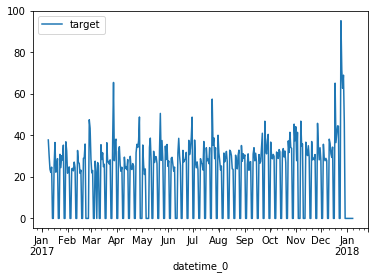

,datetime_0,target
323,2017-01-09,37.798370
1,2017-01-10,30.231827
124,2017-01-11,23.712473
69,2017-01-12,22.161023
202,2017-01-13,24.699353
342,2017-01-14,0.000000
107,2017-01-15,0.000000
109,2017-01-16,25.932234
164,2017-01-17,36.577760
102,2017-01-18,22.266876


In [12]:
df.sort_values('datetime_0').plot(x='datetime_0', y='target')
plt.show()
display(df[['datetime_0', 'target']].sort_values('datetime_0').head(15))

Предыдущий день

In [13]:
df_1 = df.shift(-1)
df_1.columns = [f'{col}__1' for col in df_1.columns]

Агрегации за период

In [14]:
dt_dt_features

['dt_number_weekday_datetime_0',
 'dt_number_month_datetime_0',
 'dt_number_day_datetime_0',
 'dt_number_hour_datetime_0',
 'dt_number_hour_of_week_datetime_0',
 'dt_number_minute_of_day_datetime_0']

In [15]:
aggregations = ['sum', 'count', 'std', 'min', 'max']
df_month = df.groupby('dt_number_month_datetime_0').agg(aggregations)
df_month.columns = ['_'.join(col).strip() for col in df_month.columns.values]

In [16]:
x = pd.concat([df, df_1], axis=1)
x = x.merge(df_month, left_on='dt_number_month_datetime_0', right_index=True)

In [11]:
pipeline, df_x = transform_data(df_x, target)

------------------------------------
Time elapsed for <function create_lag_features at 0x11402f158>: 0.009007930755615234 
Columns updated: 47
----------***************-----------
------------------------------------
[1 / 3]: dt_number_weekday_datetime_0
----------***************-----------
------------------------------------
[2 / 3]: dt_number_month_datetime_0
----------***************-----------
------------------------------------
[3 / 3]: dt_number_day_datetime_0
----------***************-----------
------------------------------------
Time elapsed for <function create_aggregations at 0x11402f378>: 8.676727056503296 
Columns updated: 19565
----------***************-----------
------------------------------------
Time elapsed for <function drop_columns at 0x114028a60>: 2.53947114944458 
Columns updated: 8960
----------***************-----------


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



------------------------------------
[1 / 8573]: number_5
----------***************-----------
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-a6a9c0416024>", line 1, in <module>
    pipeline, df_x = transform_data(df_x, target)
  File "/Users/dmitrymikhailovich_/cnt/sdsj2018-automl/notebooks/utils.py", line 281, in transform_data
    pprint(f'Time elapsed for {one_hot_encoding_fast}: {time.time() - start_time} \nColumns updated: {len(categorical)}')
  File "/Users/dmitrymikhailovich_/cnt/sdsj2018-automl/notebooks/utils.py", line 141, in one_hot_encoding_fast
    else:
UnboundLocalError: local variable 'unique_value' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Library/Frameworks/Py

UnboundLocalError: local variable 'unique_value' referenced before assignment